In [1]:
import numpy as np
import pymultinest as pmn
import matplotlib as plt

import os
import corner
import glob
import sys

from astropy.cosmology import w0waCDM, Flatw0waCDM
from exoticDE_fit.genclass_cosm import Cosmology

In [74]:
### JLA data

data_path = '../jla_data/'
jla_bins = np.loadtxt(data_path + 'dist_binned.txt') ### original
cov_mat = np.loadtxt(data_path + 'covmat_binned.txt')

In [75]:
wwcdm = w0waCDM(H0=70., Om0=0.3, Ode0=.7, w0=-.9, wa=-.1)

In [4]:
# cosmo = Cosmology('slowroll',[0.3,0.1,70.])

In [5]:
add_ztf = True

/Users/markpoe/ZTF/lowzSN/notebooks


In [73]:
### Wfirst data 
# z_wfirst,estat_wfirst = np.loadtxt('/Users/markpoe/ZTF/exoticDE_fit/Ex_data/wfirst_noLowz.dat', usecols=[1,5],unpack=True)
# cov_sys_wfirst = np.loadtxt('/Users/markpoe/ZTF/exoticDE_fit/Ex_data/syscov_WFIRST_nolowz.txt')

# cov_stat_wfirst = np.diag(estat_wfirst**2.)
# cov_wfirst = cov_sys_wfirst + cov_stat_wfirst
# icov_wfirst = np.linalg.inv(cov_wfirst)

In [7]:
je = cosmo.luminosity_distance(z_wfirst)
l = np.sort(je)
np.savetxt('by_hand.txt', l)
wfirst_distances = np.loadtxt('by_hand.txt', usecols = 0)


In [8]:
z_ztf, sig_ztf = np.loadtxt('/Users/markpoe/ZTF/exoticDE_fit/Ex_data/ztf_msip.dat', unpack =True)
ztf_dist = cosmo.luminosity_distance(z_ztf)

In [11]:
if add_ztf:
    print ('yes')
else:
    print ('nah')
    
print (len(cov_stat_wfirst))
print (len(cov_wfirst))
print (len(icov_wfirst))
print (len(z_ztf))
print (len(sig_ztf))
print (len(z_wfirst))

print (wfirst_distances)
print (z_wfirst)
print (z_ztf)
print (sig_ztf)

yes
29
29
29
9
9
29
[38.28421234 38.48951698 38.69277694 38.9258399  39.12078219 39.30786787
 39.47921151 39.66670826 39.85645371 40.04255972 40.20979022 40.38745582
 40.56731582 40.74919508 40.92123255 41.11422903 41.3010026  41.50362639
 41.70556436 41.90779628 42.13523367 42.37524432 42.63875127 42.91799573
 43.23853271 43.60261127 44.0524556  44.6498891  45.61461534]
[0.0991 0.1083 0.1182 0.1306 0.1419 0.1536 0.1651 0.1786 0.1933 0.2088
 0.2237 0.2406 0.2589 0.2787 0.2987 0.3227 0.3476 0.3766 0.4077 0.4412
 0.4819 0.5286 0.5847 0.6502 0.7339 0.8414 0.9953 1.243  1.7802]
[0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095]
[0.05614849 0.020165   0.01680764 0.01488648 0.01263724 0.01267468
 0.01193852 0.01154684 0.01122091]


In [12]:
# ### Generate mu's by hand
# je = wwcdm.distmod((jla_bins[:,0]))
# print (len(je))
# l = np.sort(je)
# # print (l)
# np.savetxt('by_hand.txt', l)


# # om, del_w, h0, M = [model_param[i] for i in range(4)]
#     wc = Cosmology('slowroll',[om, del_w, h0])
#     dl_mpc = wc.luminosity_distance(z_wfirst)
#     mu_th = 5.*np.log10(dl_mpc) + 25.
#     diff_arr = mu_th - wfirst_distances + M
#     chisq = np.dot(diff_arr.T, np.dot(icov_wfirst, diff_arr)) + ((om - 0.3)**2.)/((.01)**2.)

In [13]:
# #define all the data here (currently SN only)

# vs = np.vstack([sorted(jla_bins[:, 0]), sorted(jla_bins[:, 1])]).T # Transpose using jla original
# vv = np.vstack([sorted(jla_bins[:, 0]), (j)]).T # Transpose using the by-hand array

# np.savetxt('../jla_data/dist_binned_A.txt', vs) # Save the .T matrix
# np.savetxt('../jla_data/dist_binned_B.txt', vv) # Save the .T matrix using the by-hand array

# jla_bins_a = np.loadtxt(data_path + '/dist_binned_A.txt') # Load the .T matrix
# jla_bins_b = np.loadtxt('../jla_data/dist_binned_B.txt')# Load the .T-by-hand matrix

# cov_mat *= 1e-6
# Cinv = np.linalg.inv(cov_mat)

In [66]:
def llhood(model_param, ndim, npar): 
    """
    This is the function where we define the log likelihood 
    log(Lhood) = -0.5*chisquare
    
    Parameters
    ----------
    model_param : sequence
        sequence of model parameters (Om, w0, wa, H0, M)
        in a w0waCDM    
    ndim : integer
         length of model_params
    npar : integer
        The number of parameters 
    """
    # Calculate mu using priors and z from jla
    om, W0, Wa, h0, M = [model_param[i] for i in range(5)]
    # Define a model using priors
    wc = w0waCDM(H0=h0, Om0=om, Ode0=1-om, w0=W0, wa=Wa) #
    dl_mpc = wc.luminosity_distance(z_wfirst).value 
    mu_th = 5.*np.log10(dl_mpc) + 25.
    # Calulate chi2 using (mu_th) - (mu_some_input_such_as_jla or by hand) 
    dif_arr = mu_th - wfirst_distances + M # Using by-hand data
    chisq = np.dot(dif_arr.T, np.dot(icov_wfirst, dif_arr)) + ((om - 0.3)**2.)/((.01)**2.)

    # Adding in ZTF
    if add_ztf:
        mu_th_ztf = wc.distmod(z_ztf).value
        del_ztf = mu_th_ztf - ztf_dist + M
        a = np.sum(del_ztf**2/sig_ztf**2)
        b = np.sum(del_ztf/sig_ztf**2)
        c = np.sum(1/sig_ztf**2)
        ztf_chi2 = a - (b**2)/c + np.log(c/(2*np.pi))
        chisq += ztf_chi2
        print ('ztf')
    
    return -0.5*chisq

def prior(cube, ndim, npar): # for models with more pars
    """
    Define the prior for each parameter
    cube[0] = om
    cube[1] = w0
    cube[2] = wa
    cube[3] = H0
    cube[4] = M
    """
    cube[0]  = cube[0]*1.
    cube[1]  = cube[1]*4. - 2.
    cube[2]  = cube[2]*6. - 3.
    cube[3]  = cube[3]*50. + 50.
    cube[4]  = cube[4]*0.00000000000001

# Functions for fitting slowroll distances to slowroll
def llhood_slowroll(model_param, ndim, npar):
    """Function similar to llhood that's built exclusively for the slowroll model
       Log=True in this case so we use .luminosity_distance(some_z) for the dist mod 
    """
    
    om, del_w, h0, M = [model_param[i] for i in range(4)]
    wc = Cosmology('slowroll',[om, del_w, h0])
#     mu_th = wc.distmod(z_wfirst)
    mu_th = wc.luminosity_distance(z_wfirst)
    diff_arr = mu_th - wfirst_distances + M
    chisq = np.dot(diff_arr.T, np.dot(icov_wfirst, diff_arr)) #+ ((om - 0.3)**2.)/((.01)**2.)
    return -0.5*chisq

def prior_slowroll(cube, ndim, npar):
    """ Prior function built for the slowroll model
    cube[0] = om
    cube[1] = del_w
    cube[2] = h0
    cube[3] = M """
    
    cube[0] = cube[0]*1.
    cube[1] = cube[1]*.6 - .3
    cube[2] = cube[2]*45. + 45. 
    cube[3] = cube[3]*0.0000000000001

    

# # Similarly defined functions for running model comparisons at the same time
# def llhood2(model_param, ndim, npar):
#     om, w, h0, M = [model_param[i] for i in range(4)]
    
#     wc = wCDM(H0=h0, Om0=om, Ode0=1-om, w0=w)
# #     wc = FlatwCDM(H0=H0, Om0=om, w0=w)

#     dl_mpc = wc.luminosity_distance(jla_bins[:,0]).value # Using jla data
#     mu_th = 5*np.log10(dl_mpc) + 25.
    
# #     dif_arr = mu_th - jla_bins_a[:,1] + M # Using jla mu .T
#     dif_arr = mu_th - jla_bins_b[:,1] + M # Using by-hand data
    
#     chisq = np.dot(dif_arr.T, np.dot(Cinv, dif_arr)) + ((om - 0.3)**2.)/((1e-15)**2.)
#     return -0.5*chisq
    
# def prior2(cube, ndim, npar): # for models with less pars
#     cube[0]  = cube[0]*1
#     cube[1]  = cube[1]*4 - 2
#     cube[2]  = cube[2]*50 + 50
#     cube[3]  = cube[3]*0.00000000000001

In [70]:
prefix = 'wf_ztf_sr_1'
chain_dir = ('/Users/markpoe/ZTF/lowzSN/notebooks/chains/' + prefix + '/')

if not os.path.exists(chain_dir):
    os.makedirs(chain_dir)

# ## For running model comparisons at the same time
# prefix2 = 'new_class_trial_run'
# chain_dir2 = ('/Users/markpoe/ZTF/lowzSN/notebooks/chains/' + prefix2 + '/')

# if not os.path.exists(chain_dir2):
#     os.makedirs(chain_dir2)

In [68]:
# pmn.run(llhood, prior, 5, verbose=True, n_live_points=700, outputfiles_basename=chain_dir)
pmn.run(llhood_slowroll, prior_slowroll, 4, verbose=True, n_live_points=400, outputfiles_basename=chain_dir)


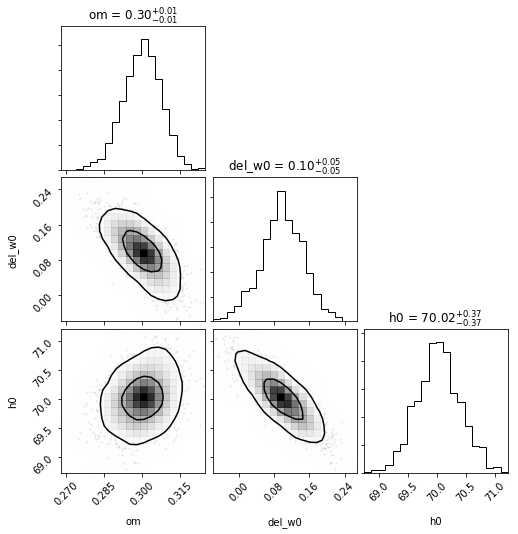

In [69]:
data = np.loadtxt(chain_dir+'post_equal_weights.dat')
# figure = corner.corner(data[:,[0,1,2,3]], smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.) ), labels=['om', 'w0', 'wa', 'h0', 'M', 'llhood'], show_titles=True)#, truths=[.3,-.9,-.1,70.,None,None])
figure = corner.corner(data[:,[0,1,2]], smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.) ), labels=['om', 'del_w0', 'h0', 'llhood'], show_titles=True)#, truths=[.3,-.9,-.1,70.,None,None])


# data2 = np.loadtxt(chain_dir2+'post_equal_weights.dat')
# figure2 = corner.corner(data2[:,[0,1]], smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.) ), labels=['om', 'w','h0', 'M', 'llhood'],show_titles=True, truths=[.3,-.9,70.,None,None])

# plt.pyplot.savefig['/Users/markpoe/ZTF/lowzSN/notebooks']
figure.savefig('./plots/contours/'+prefix)

In [15]:

### Find log evidence and calculate delta log evidence for two models

# Define variables for use in a loop
chains_directory = '/Users/markpoe/ZTF/lowzSN/notebooks/chains/'
stat = '/stats.dat'
model_one =  prefix # i.e. 'test6_modchi2'
model_two =  prefix2 # i.e. 'jla_wCDM_vs_by_hand2'
Model_1 = chains_directory + model_one +  stat
Model_2 = chains_directory + model_two +  stat


# Build array of log evs for two models
ev = []
models = [Model_1,Model_2]
for x in models:
    with open(x, "r") as f:
        for line in f:
            if "Nested Sampling Global Log-Evidence" in line:
                ev.append(line)
    f.close()
print (ev)


# Extract the evidences from the above array and convert to float
z = []
for x in ev:
    y = x.split(':')
    t = y[1].split('+/-')
    z.append(t[0])
ev1,ev2 = float(z[0]), float(z[1])
print ('\n','Log evs as floats','\n',ev1,ev2)


# Calculate and print delta of the log evidences
delta_lnE = np.abs(ev1 - ev2)
print ('\n','Delta Log Evidence of the two models','\n',delta_lnE)


['Nested Sampling Global Log-Evidence           :   -0.961122045829845462E+01  +/-    0.105035256498742569E+00\n', 'Nested Sampling Global Log-Evidence           :   -0.344400747657029669E+02  +/-    0.211098081439508617E+00\n']

 Log evs as floats 
 -9.611220458298455 -34.44007476570297

 Delta Log Evidence of the two models 
 24.828854307404512


In [36]:
print (z_wfirst)


[0.0991 0.1083 0.1182 0.1306 0.1419 0.1536 0.1651 0.1786 0.1933 0.2088
 0.2237 0.2406 0.2589 0.2787 0.2987 0.3227 0.3476 0.3766 0.4077 0.4412
 0.4819 0.5286 0.5847 0.6502 0.7339 0.8414 0.9953 1.243  1.7802]


In [244]:

# Print evidences and the abs value of delta evidences
e1 = np.exp(ev1)
e2 = np.exp(ev2)
print (e1)
print (e2)
delta_evidence = np.abs(e1 - e2)
print ('\n','Delta evidence','\n', delta_evidence)


# Print Bayes factor ev1/ev2
Bayes_factor = np.divide(np.exp(ev1),np.exp(ev2))
# Bayes_factor = np.divide(np.exp(ev2),np.exp(ev1))

# Print log of the Bayes Factor, should be same as delta log evs
log_bayes_factor = np.abs(np.log(Bayes_factor))
print ('\n','Log Bayes Factor (Delta Log evs)','\n',log_bayes_factor)


# If the log bayes is negative, can use this to find bayes factor
# Bayes factor for real this time
Bayes_factor = np.exp(np.abs(log_bayes_factor))
print ('\n','Bayes Factor','\n',Bayes_factor)


3.3341866707294397e-06
0.00022955702035849787

 Delta evidence 
 0.00022622283368776844

 Log Bayes Factor (Delta Log evs) 
 4.231922680579913

 Bayes Factor 
 68.84948055661091


In [18]:
a = pmn.analyse.Analyzer(5, outputfiles_basename = chain_dir)

  analysing data from /Users/markpoe/ZTF/lowzSN/notebooks/chains/test1_jla_w0waCDM/.txt


In [21]:
a.get_data()